In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import time
from tqdm import trange

In [2]:
from neural_nets import q_network, p_network, d_network
from sample_env import EnvSampler
from replay_memory import MemoryElement, ReplayMemory
from models import DynamicEnsemble, SAC
from utils import get_memories_torch



In [3]:
env_ant = gym.make('Ant-v4')
env_hopper = gym.make("Hopper-v4")
env_humanoid = gym.make("Humanoid-v4")
env_cheetah = gym.make("HalfCheetah-v4")

envs = [env_ant, env_hopper, env_humanoid, env_cheetah]

In [16]:
help(env_cheetah.data.body)

Help on method body in module mujoco._structs:

body(...) method of mujoco._structs.MjData instance
    body(*args, **kwargs)
    Overloaded function.
    
    1. body(self: mujoco._structs.MjData, arg0: int) -> mujoco::python::MjDataBodyViews
    
    2. body(self: mujoco._structs.MjData, arg0: str) -> mujoco::python::MjDataBodyViews



In [4]:
mem = ReplayMemory(10001)

In [8]:
env_name = 'HalfCheetah-v4'
env = EnvSampler(env_name, env_number = 10)

In [9]:
print(env.action_space)
print(env.observation_space)
print(env.dim)

obs_dim, act_dim = env.dim

Box(-1.0, 1.0, (6,), float32)
Box(-inf, inf, (17,), float64)
(17, 6)


In [10]:
for _ in range(1):
    for i in range(1000):
        this = env.sample()
        if not isinstance(this[0], MemoryElement):
            print(this)
        mem.push(this)

    states, actions, rewards, next_states, terminals, truncateds = mem.sample_numpy()
    
print(len(mem))

10000


In [11]:
def evaluate(agent, env):
    env.reset()

    trajectories = [[] for i in range(len(env))]

    rewards = [0. for i in range(len(env))]
    complete_trajectories = []
    complete_indexes = []
    while True:
        memories = env.sample(agent=agent)

        for ix, mem in enumerate(memories):
            if ix in complete_indexes:
                continue

            trajectories[ix].append(mem)
            rewards[ix] += mem.reward
            
            if mem.terminal or mem.truncated:
                complete_trajectories.append(trajectories[ix])
                complete_indexes.append(ix)

        if len(complete_indexes) == len(env):
            break

    lengths = np.asarray([len(traj) for traj in complete_trajectories])
    rewards = np.asarray(rewards)
    
    return rewards.mean(), rewards.std(), lengths.mean(), lengths.std()

In [15]:
agent = SAC(env)

In [16]:
evaluate(agent,env)

(-516.493025750014, 84.3960863672085, 1000.0, 0.0)

In [17]:
means_fwd = []
means_ctrl = []

In [16]:
for ep in trange(10):

    

    rewards,_, lengths,_ = evaluate(agent, env)
    rewards, lengths = np.mean(rewards), np.mean(lengths)

    means_fwd.append(rewards)
    means_ctrl.append(lengths)
    
    for i in range(100):
        agent.update_params(mem.sample())

100%|███████████████████████████████████████████| 10/10 [02:24<00:00, 14.44s/it]


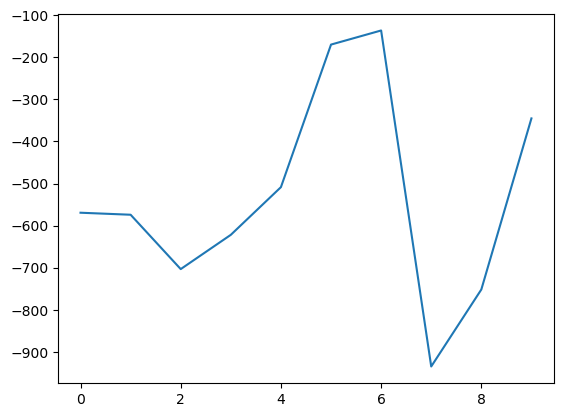

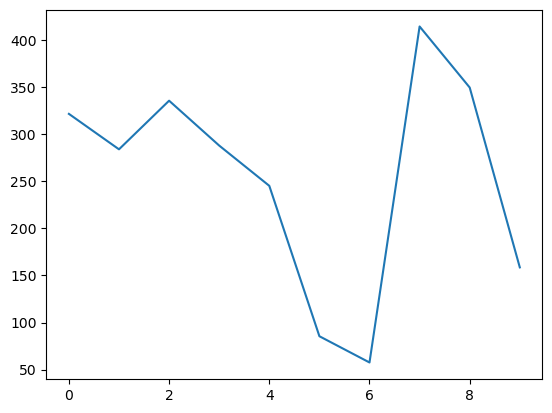

In [17]:
plt.plot(means_fwd)
plt.show()
plt.plot(means_ctrl)
plt.show()

In [20]:
help(env.envs[0])

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(env: gym.core.Env, max_episode_steps: Optional[int] = None)
 |  
 |  This wrapper will issue a `truncated` signal if a maximum number of timesteps is exceeded.
 |  
 |  If a truncation is not defined inside the environment itself, this is the only place that the truncation signal is issued.
 |  Critically, this is different from the `terminated` signal that originates from the underlying environment as part of the MDP.
 |  
 |  Example:
 |     >>> from gym.envs.classic_control import CartPoleEnv
 |     >>> from gym.wrappers import TimeLimit
 |     >>> env = CartPoleEnv()
 |     >>> env = TimeLimit(env, max_episode_steps=1000)
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: gym.core.Env, max_episode_steps: Optional[int] = Non

In [9]:
states, actions, rewards, next_states, terminals, truncateds = mem.sample_numpy()

In [11]:
rewards.shape

(256, 1)

In [12]:
print(next_states.shape)
print(rewards.shape)

(256, 27)
(256,)


In [7]:
model = DynamicEnsemble(5, env)

In [8]:
model.update_params(mem)

In [9]:
next_state, reward = model.forward_all(states,actions, to_cpu=False)

In [10]:
next_state.shape

torch.Size([5, 256, 27])

In [16]:
dnet = d_network(obs_dim, act_dim)
dnet_out = dnet(states,actions)
dnet_sample = dnet.sample(states,actions)

pnet = p_network(obs_dim, act_dim)
mean, log = pnet(states)
pnet_sample = pnet(states)


qnet = q_network(obs_dim, act_dim)
qnet_out1, qnet_out2 = qnet(states,actions)

In [15]:
print('dnet')
print(dnet_out[0].shape)
print(dnet_out[1].shape)
print(dnet_sample.shape)

print('pnet')
print(pnet_out[0].shape)
print(pnet_out[1].shape)
print(pnet_sample[0].shape)
print(pnet_sample[1].shape)
print('qnet')

print(qnet_out1.shape)
print(qnet_out2.shape)

dnet
torch.Size([15, 28])
torch.Size([15, 28])
torch.Size([15, 28])
pnet
torch.Size([15, 8])
torch.Size([15, 8])


TypeError: 'tuple' object does not support item assignment

[ -153.34107573 -1929.95198287  -164.15092036  -108.24414074
  -132.11390995   -38.53513028   -38.58429689   -69.08221558
   -98.91029752   -96.75420586]
[ 13  18  29  35  44  46  52  56  57 776]


(-282.96681757831664, 550.5027726641139, 112.6, 221.6051443446203)

In [10]:
env.sample(agent=agent)

In [13]:
actions, log_prob = agent.act(env.current_states, to_cpu= True)

/home/boz/Desktop/is/WS2223/RL/code/utils.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  x = torch.tensor(x)


In [20]:
next_state, reward, terminal,truncated, info = env.envs[0].step(actions[0])

In [ ]:
actions

In [12]:
env.sample()

In [35]:
low = env.envs[0].action_space.low[0]
high = env.envs[0].action_space.high[0]
shape = env.envs[0].action_space.shape[0]

In [41]:
np.random.uniform(low,high,size = (10,shape))

array([[-0.75605283,  0.45315103, -0.44038071, -0.39918371,  0.89899447,
         0.57142034, -0.92090965,  0.10834664],
       [ 0.83571983, -0.89634548,  0.61270025, -0.11024773, -0.87044899,
        -0.20681211, -0.26284156, -0.53893266],
       [ 0.58053186, -0.22375027,  0.99358448, -0.83943068,  0.93893273,
        -0.51941789,  0.20930903, -0.83049272],
       [-0.2948783 ,  0.60855263,  0.23502916,  0.51622193,  0.94318343,
         0.02795306,  0.89869769,  0.14365305],
       [-0.1572034 , -0.16973196, -0.97560081, -0.05422376, -0.67944308,
         0.04657044,  0.22074123,  0.28020859],
       [ 0.85764886,  0.03316789, -0.64132589, -0.98379484,  0.91148541,
         0.32669071,  0.16841558,  0.49973345],
       [-0.37111905,  0.74332585,  0.79130651, -0.44536933, -0.3662349 ,
        -0.69318974,  0.45024328,  0.95528467],
       [-0.13737883, -0.04238112, -0.70547295, -0.72003842,  0.65047193,
         0.20711383,  0.86395475,  0.32057053],
       [ 0.54411852, -0.21632309

In [44]:
actions, log_probs = agent.act(np.asarray([env.current_states[0]]), to_cpu = True)

In [45]:
actions.shape

(1, 8)

In [49]:
env.envs

[<TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>,
 <TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>]

In [16]:
env.reset()

In [19]:
next_state, reward, terminal,truncated, info = env.envs[0].step(env.action_space.sample())

In [20]:
reward

-0.3518987618771099

In [21]:
info

{'reward_forward': -0.5192271195736431,
 'reward_ctrl': -0.8326716423034668,
 'reward_survive': 1.0,
 'x_position': 0.41163037620499576,
 'y_position': -0.17830548141839356,
 'distance_from_origin': 0.44858935711685294,
 'x_velocity': -0.5192271195736431,
 'y_velocity': 0.6607935496364303,
 'forward_reward': -0.5192271195736431}

In [1]:
env.sample(agent=agent)

NameError: name 'env' is not defined

In [12]:
env = gym.make('HalfCheetah-v4')

In [21]:
env.env.check_done

AttributeError: 'HalfCheetahEnv' object has no attribute 'check_done'

In [62]:
states = np.asarray([env.observation_space.sample() for i in range(10)])


check_hopper_done(states)

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True])

In [24]:
def check_hopper_done(states):
    if len(states.shape) == 1:
        states = states.reshape(1,-1)
    heights, angs = states[:,0], states[:,1]
    return ~(np.isfinite(states).all(axis=1) & (np.abs(states[:,1:]) < 100).all(axis=1) & (heights > .7) & (np.abs(angs) < .2))